# 2020 Recruitment Challenge
written by Peter Biryukov (biryukov.peter@gmail.com, 0406717518)

## Notes

I decide to use Jupyter notebook, because it allows to put both python code and notes at the same notebook, so
- it is easier to write
- easier to check

It also allows notes to be in Markdown format, so they will be easier to read than just python comments


### Observations about the data

- Actual electricity demand cyclical changes during days, with two peaks, one in the late morning, one in the late evening
- The demand also has weekly changes with minimum on weekends and public holidays
- It looks like that electricity demands grows in spite of COVID

### What I would do differently if I had more time
I would:
- read about how to [seasonally adjust data](https://machinelearningmastery.com/time-series-seasonality-with-python/) correctly (in this code I just calculated average of the actual electricity demand over the past 5 years)
- discussed more what exactly should be done (I have asked Jo some questions, but for a real task I think we would have to talk more to make sure that all the requirements are correct and correctly understood)
- write unit tests

### Suggestions for progressing this work further
- Discuss and decide what exactly visualisation is required
- Put python code to *.py files, & python module
- Download input data from AEMO website using python script
- Instead of Jupyter notebook (which is good for development), develop REST api with python and flask that produces required visualisation
- Write simple web UI (for example with React) that calls this api and displays charts

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from datetime import datetime, timedelta, date
import holidays

import glob, os

### Load input data
Input data expected to be in **data** folder if they are somewhere else, update the path

In [2]:
data_path = 'data'

In [3]:
# get input data filenames
file_names = glob.glob(os.path.join(data_path, 'QLD_*'))

# load input data
data = [pd.read_csv(fn, header=0) for fn in file_names]

# put them in one DataFrame
data = pd.concat(data)

# Visualisation of a single day

>**Requirement:** At a minimum, provide this visualisation for a single day of your choosing

> **Bonus point:** Allow user to select which day to visualise

This will be a visualisation of 2020-04-08. If you want to see some other day, update values in the next cell

In [4]:
year = 2020
month = 4
day = 8

Get row with choosen day

In [5]:
row = data[(data.Year == year) & (data.Month == month) & (data.Day == day)]

Get actual Queensland electricity demand from the row (and remove year, month and day)

In [6]:
y = row.values.flatten().tolist()[3:]

Times of the demands

In [7]:
x = [(datetime(year, month, day, 4) + timedelta(minutes=30) * x).strftime("%H:%M") for x in range(48)]

Visualise data

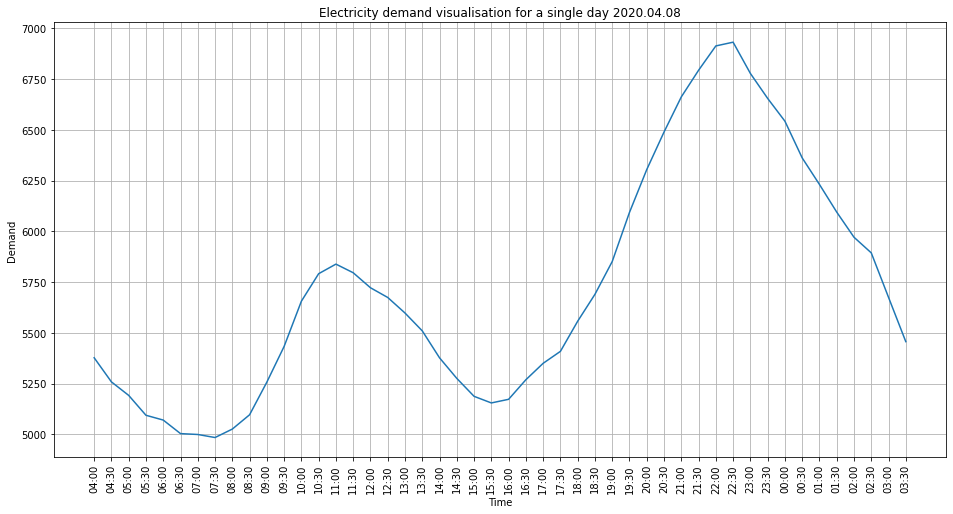

In [8]:
fig = plt.figure(figsize=(16,8))
plt.plot(x, y)
plt.xticks(rotation=90)
plt.title(f'Electricity demand visualisation for a single day {datetime(year, month, day).strftime("%Y.%m.%d")}')
plt.xlabel("Time")
plt.ylabel("Demand")
plt.grid()
plt.show()

Interestingly, a day has two local maximums on in about 11:00 another in about 22:30

This function is similar to the code above, but it can visualise deveral days

In [9]:
def draw_days(year, month, day, ndays=7):
    "Darw ndays starting from (year, month, day)"

    days = list(range(day, day + ndays))

    rows = data[(data.Year == year) & (data.Month == month) & (data.Day.isin(days))]

    y =[]
    x_ticks = []
    x_labels = []
    for _, row in rows.iterrows(): 
        x_ticks += [len(y)]
        x_labels += [datetime(int(row.Year), int(row.Month), int(row.Day), 4).strftime("%d %b, %Y")]
        y += row.values.flatten().tolist()[3:]


    # last tick and empty label
    x_ticks += [len(y)]
    x_labels += [""]


    fig = plt.figure(figsize=(16,8))
    plt.plot(y)

    plt.title(f'Electricity demand visualisation for {ndays} day(s) starting from'
              f'{datetime(year, month, day).strftime("%Y.%m.%d")}')
    plt.xlabel("Time")
    plt.xticks(ticks=x_ticks, labels=x_labels, ha='left')

    plt.ylabel("Demand")
    plt.grid()
    plt.show()

> **Requirement bonus point:** Provide visualisation for an entire week

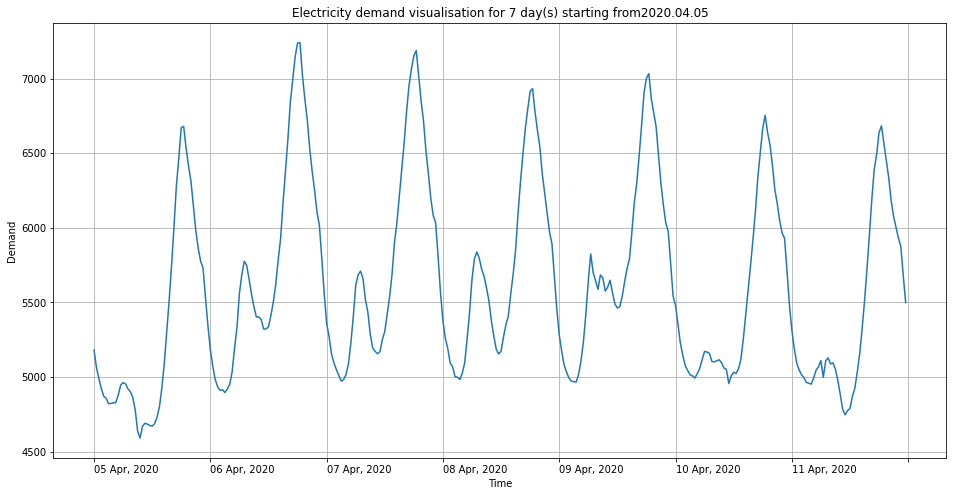

In [10]:
draw_days(2020, 4, 5)

And as before days have two local maximums

# Other Deliverables

**from Jo Kelly-Fenton email:**
In response to the challenge, you can disregard the 2020 historical data contained in QLD_demand_2019.csv data. So you would only use July - Dec 2019 of the historical data found in that csv. 

In [11]:
data2020 = data[(data.Year == 2020)].copy()
data = data[(data.Year != 2020)]

### Prepare CSV file of predicted half-hourly Queensland electricity demand for 2020 (based on historic average)

The next several cells produce CSV file of predicted half-hourly Queensland electricity demand for 2020 (based on historic average). They calculate average prices for all the historical data and save them to a file.

Output file for predicted half-hourly Queensland electricity demand for 2020

In [12]:
fn = 'Predicted_QLD_demand_2020.csv'

Calculate averages for all the years

In [13]:
avg = data.groupby(by=['Month', 'Day']).mean()
del avg['Year']
avg.reset_index(inplace=True)

Save CSV file of predicted half-hourly Queensland electricity demand for 2020

In [14]:
avg.to_csv(fn, index=False)

## Daily electricity demand for April 2020


There are actual values for April 2020 and the values that were predicted based on historical average

In [15]:
monthNum = 4

In [16]:
april_predicted = avg[avg.Month == monthNum]
april_actual = data2020[data2020.Month == monthNum]

Calculate daily demands

In [17]:
def calculate_daily_demand(month):
    "This function calculates daily electricity demand"
    days = month.Day
    result = month.drop(columns = ['Month', 'Day'])
    result = pd.DataFrame({'Day': month.Day,
                           'Demand': month.sum(axis=1)/len(month)})
    return result

daily_demand_predicted = calculate_daily_demand(april_predicted)
daily_demand_actual = calculate_daily_demand(april_actual)

Draw daily electricty demand

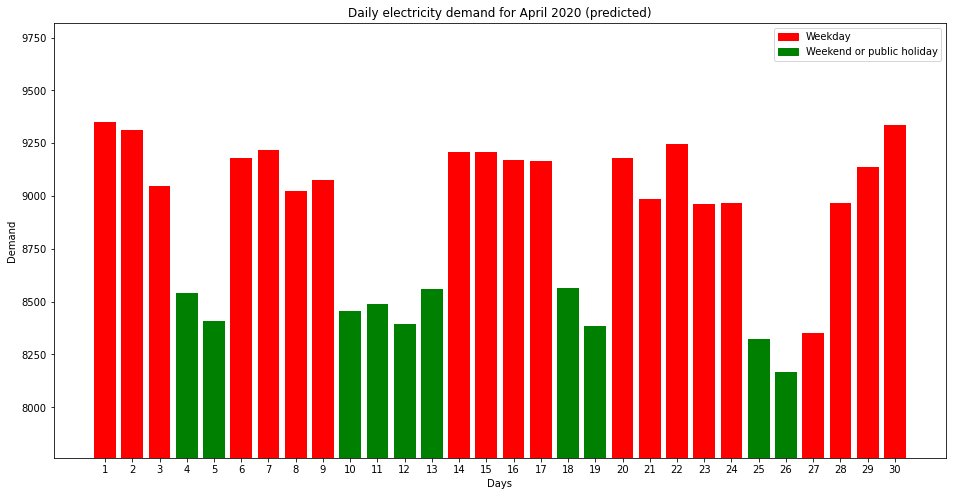

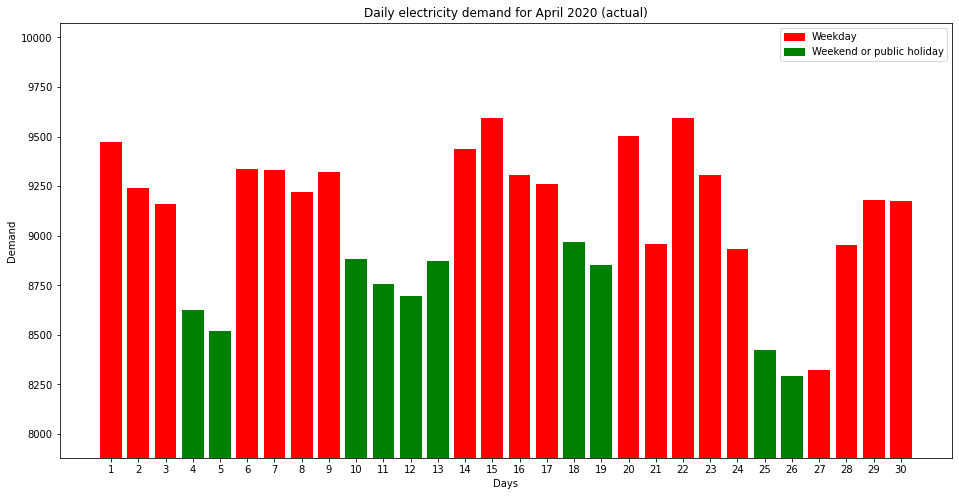

In [18]:
def draw_daily_demand(month, title):
    "This function draws electricity demand"
    
    fig = plt.figure(figsize=(16,8))
    
    qld_holidays = holidays.Australia(state='QLD', years=2020)
    def is_holiday(day):
        "returns true if day is public holiday or weekend"
        d = date(2020, monthNum, day)
        if d.isoweekday() in [6, 7]:
            return True
        if d in qld_holidays:
            return True
        return False

    colors = ['g' if is_holiday(d) else 'r' for d in month.Day]
    
    plt.bar(month.Day, month.Demand, color=colors)

    plt.title(f'Daily electricity demand for April 2020 ({title})')

    plt.xlabel("Days")
    plt.xticks(ticks=month.Day)

    plt.ylabel("Demand")

    ax = plt.gca()
    y_min = month.Demand.min() * 0.95
    y_max = month.Demand.max() * 1.05
    ax.set_ylim([y_min, y_max])


    weekday = mpatches.Patch(color='red', label='Weekday')
    weekend = mpatches.Patch(color='green', label='Weekend or public holiday')
    plt.legend(handles=[weekday, weekend])

    plt.show()
    
draw_daily_demand(daily_demand_predicted, 'predicted')
draw_daily_demand(daily_demand_actual, 'actual')

As it can be seen from the charts electricity demand is lower on public holidays and weekends. An interesting day is April 27. There is public holiday on April 25 (Anzac day), and Monday April 27 is not a public holiday in QLD, but it still has low electricity demand.

The next chart compares actual and average hictorical demand 

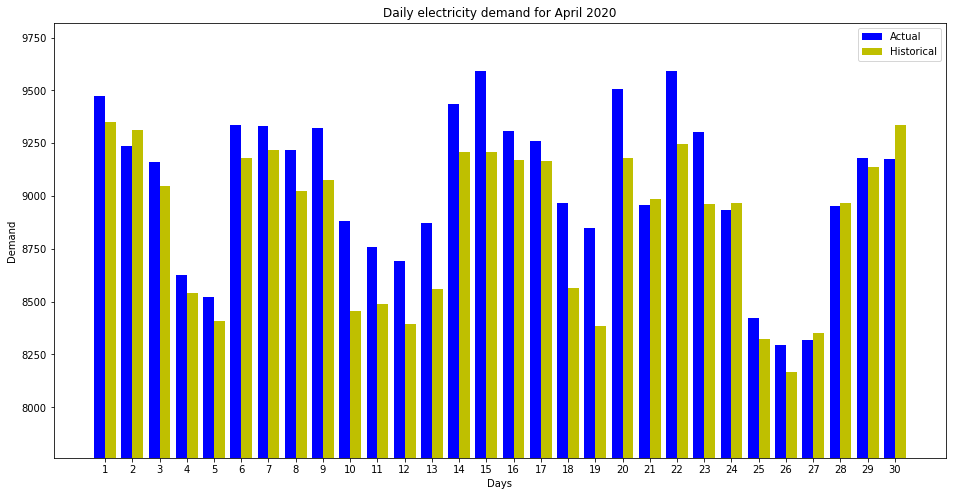

In [19]:
fig = plt.figure(figsize=(16,8))

plt.bar(daily_demand_actual.Day    - 0.2, daily_demand_actual.Demand,    width=0.4, color='b', label='Actual')
plt.bar(daily_demand_predicted.Day + 0.2, daily_demand_predicted.Demand, width=0.4, color='y', label='Historical')

plt.title('Daily electricity demand for April 2020')

plt.xlabel("Days")
plt.xticks(ticks=daily_demand_predicted.Day)

plt.ylabel("Demand")

ax = plt.gca()
y_min = daily_demand_predicted.Demand.min() * 0.95
y_max = daily_demand_predicted.Demand.max() * 1.05
ax.set_ylim([y_min, y_max])

plt.legend()
plt.show()

It looks like electricity demand in 2020 is higher in most days of April than historical average demand

Save demand to CSV file

In [20]:
fn = 'April_daily_electricity_demand.csv'
daily_demand_predicted.to_csv(fn, index=False)